In [ ]:
! pip install openai==1.58.1 langchain==0.3.12 langchain_openai==0.2.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25


In [ ]:
# 設定 環境變數
import os
from google.colab import userdata

# 設定 OpenAI API Key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# 設定 LangSmith 的一些環境變數
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'STORM-Exp'
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')

# 最簡單的 LCEL 範例

In [ ]:
from langchain_openai import ChatOpenAI

# 建立使用的 LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")

# OpenAI Chat Completion 資料結構  
OpenAI 角色定義 -> LangChain 定義  

---

System -> System Message  
Assistant -> AI Message  
User -> Human Message

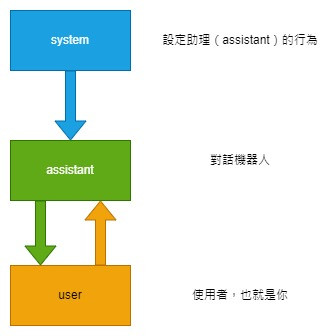

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(content="將以下訊息翻譯為中文。"),
    HumanMessage(content="hi!"),
]

llm.invoke(messages)

AIMessage(content='嗨！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 30, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0f2aae99-2662-4eac-866d-6fc82a578201-0', usage_metadata={'input_tokens': 30, 'output_tokens': 5, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# 使用 OutputParser

In [ ]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

In [ ]:
result = llm.invoke(messages)

In [ ]:
parser.invoke(result)

'嗨！'

# 如何將流程【串】（chain）在一起？

In [ ]:
chain = llm | parser

In [ ]:
chain.invoke(messages)

'嗨！'

TODO: {查看 LangSmith}

# 使用提示範本（PromptTemplate）

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
system_template = "將以下訊息翻譯為 {language}:"

In [ ]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", system_template),
        ("user", "{text}")
    ]
)

In [ ]:
result = prompt_template.invoke({
  "language": "中文",
  "text": "hi"
})

result

ChatPromptValue(messages=[SystemMessage(content='將以下訊息翻譯為 中文:', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi', additional_kwargs={}, response_metadata={})])

In [ ]:
result.to_messages()

[SystemMessage(content='將以下訊息翻譯為 中文:', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]

# 將 PromptTempalte / LLM / OutputParser 串（Chain）在一起

In [ ]:
chain = prompt_template | llm | parser

In [ ]:
chain.invoke({"language": "中文", "text": "hi"})

'嗨! 有什麼可以幫助您的嗎？'

# STORM 應用實例
- 產生相關主題

In [ ]:
topic = '建立一個專業的 LinkIn 首頁'

In [ ]:
# Prompt
prompt_sub_topic = ChatPromptTemplate.from_messages([
    ("system", """
        我想寫一篇關於某個主題的長篇文章。我會給你主題，我希望你能提出 {subtopic_count} 個相關的子主題來擴展內容。
    """),
    ("user", """
        主題： {topic}
    """),
])

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Chain
chain_sub_topic = (
    prompt_sub_topic
    | llm
    | StrOutputParser()
)

In [ ]:
related_topic_result = chain_sub_topic.invoke({
  'topic':'建立一個專業的 LinkIn 首頁',
  'subtopic_count': 3
})




In [ ]:
related_topic_result

'子主題一： 個人資料優化\n子主題二： 精選展示作品\n子主題三： 積極參與社群與互動'

# 產生各類觀點

In [ ]:
from langchain_core.output_parsers import NumberedListOutputParser

numbered_list_output_parser = NumberedListOutputParser()

# Prompt
# 下方 system prompt 不一定需要 {format_instructions}
prompt_perspectives = ChatPromptTemplate.from_messages([
    ("system", """
        你需要選擇一組由 {perspective_count} 位作家組成的團隊，他們將共同撰寫一篇關於這個主題的綜合性文章。每位作家都代表與此主題相關的不同觀點、角色或隸屬關系。
        你可以使用其他相關主題作為靈感。對於每個角色，添加他們將重點關注的描述。請嚴格按照以下格式回答，不要添加任何額外內容：1. 第一位作家的可能職稱：觀點描述 \n 2. 第二位作家的可能職稱：[觀點描述 \n...\n\n


    """),
    ("user", """
        主題： {topic}
        相關主題：{related_topics}
    """),
])

# 如果使用 system message 使用 {format_instructions}，則需要如下指定 format_instructions 的格式。
#prompt_perspectives = prompt_perspectives.partial(format_instructions=numbered_list_output_parser.get_format_instructions())

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Chain
chain_perspectives = (
    prompt_perspectives
    | llm
    | numbered_list_output_parser
)

In [ ]:
perspectives_result = chain_perspectives.invoke({
    'perspective_count': 3,
    'topic': topic,
    'related_topics': related_topic_result

})

In [ ]:
perspectives_result

['第一位作家的可能職稱：網路品牌顧問', '第二位作家的可能職稱：視覺設計師', '第三位作家的可能職稱：社群經理']

# 如何將兩個 chain 再串在一起？

In [ ]:
from langchain_core.runnables import RunnablePassthrough

In [ ]:
chain_combine = (
  chain_sub_topic
  | { # 這個就是 Runnable Branch 的一種撰寫格式範例
      'topic': lambda _: topic,
      'related_topics': RunnablePassthrough(),
      'perspective_count': lambda _: 3,
  }
  | chain_perspectives
)

In [ ]:
combine_result = chain_combine.invoke({
    'topic': topic,
    'subtopic_count': 3,
})

In [ ]:
combine_result

['**個人資料設定與維護**：',
 '**職業形象設計師**：強調如何透過視覺設計和個人品味來打造引人注目的個人檔案，包括封面照片和頭像的選擇，以及簡介的撰寫技巧。',
 '**有效的社交互動策略**：',
 '**社交專家**：專注於建立有意義的人脈關係和有效的互動策略，包括如何在 LinkedIn 上建立良好的互動，提高曝光率和建立專業形象。',
 '**個人品牌建立與維護**：',
 '**品牌營銷專家**：關注如何透過內容創作、推薦信的管理和與業界專家互動來建立個人品牌，提升專業聲譽和信任度。']

# 同學的練習
- 將以上程式碼執行一次，確認可以執行
- 修改 & 執行【最簡單的 LECL 範例】的提示詞
    - 查看 [LangSmith](https://www.langchain.com/langsmith)，觀察執行過程
- 修改 & 執行【使用提示範本】的提示詞
    - 查看 [LangSmith](https://www.langchain.com/langsmith)，觀察執行過程
- 【STORM 應用實例】段落，修改 topic 並且執行看看
    - 查看 [LangSmith](https://www.langchain.com/langsmith)，觀察執行過程
- 給同學 10 分鐘的時間練習